In [1]:
import torch
device = 'cuda' if torch.cuda.is_available else 'cpu'
from agent import Agent, advanced_random_policy, random_policy, sarsa
from game import Game
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Trains and test a single Agent

agent = Agent(size=3)
random_agent = Agent(size=3, policy=advanced_random_policy)
game = Game(agent, random_agent, n_dim=2, size=3)
sarsa(game, agent, random_policy, alpha=0.8, alpha_factor=0.999, gamma=0.9, epsilon=1.0, epsilon_factor=0.999, \
      r_win=5.0, r_lose=0.0, r_even=1.0, r_even2=1.5, num_episodes=10000)

100%|██████████| 10000/10000 [01:15<00:00, 132.98it/s]


In [4]:
game.simulate_games(1000)

(230, 0, 270, 0, 29, 471)

In [5]:
game.play_a_game()

. . . 
. . . 
. . . 

Agent plays : (0, 2) 

. . X 
. . . 
. . . 

Agent plays : (2, 1) 

. . X 
. . . 
. O . 

Agent plays : (0, 1) 

. X X 
. . . 
. O . 

Agent plays : (0, 0) 

O X X 
. . . 
. O . 

Agent plays : (2, 0) 

O X X 
. . . 
X O . 

Agent plays : (1, 1) 

O X X 
. O . 
X O . 

Agent plays : (2, 2) 

O X X 
. O . 
X O X 

Agent plays : (1, 2) 

O X X 
. O O 
X O X 

Agent plays : (1, 0) 

O X X 
X O O 
X O X 

Game over. Score : (0, 0)
Even score.


(0, 0)

In [6]:
# Evaluates agents performances based on number of episodes
episodes = [1, 10, 100, 500, 1000, 5000, 10000]
results_episodes = dict()
for eps in episodes:
    print(f"Testing with {eps} episodes")
    agent = Agent(size=3)
    random_agent = Agent(size=3, policy=random_policy)
    game = Game(agent, random_agent, n_dim=2, size=3)
    sarsa(game, agent, random_policy, alpha=0.45, alpha_factor=0.9995, gamma=0.7, epsilon=1.0, epsilon_factor=0.9997, \
          r_win=11, r_lose=0.0, r_even=1.0, r_even2=1.25, num_episodes=eps)
    results_episodes[eps] = game.simulate_games(10000)
    print(f"Current results are {results_episodes}")
results_episodes = pd.DataFrame(results_episodes).T
results_episodes.columns = ["win_agent_first", "lose_agent_first", "even_agent_first", "win_agent_second", "lose_agent_second", "even_agent_second"]

100%|██████████| 10000/10000 [01:10<00:00, 142.27it/s]


Testing with 1 episodes
Current results are {1: (2906, 1477, 617, 1473, 2887, 640)}
Testing with 10 episodes
Current results are {1: (2906, 1477, 617, 1473, 2887, 640), 10: (2905, 1418, 677, 1385, 2964, 651)}
Testing with 100 episodes
Current results are {1: (2906, 1477, 617, 1473, 2887, 640), 10: (2905, 1418, 677, 1385, 2964, 651), 100: (3580, 978, 442, 1817, 2591, 592)}
Testing with 500 episodes
Current results are {1: (2906, 1477, 617, 1473, 2887, 640), 10: (2905, 1418, 677, 1385, 2964, 651), 100: (3580, 978, 442, 1817, 2591, 592), 500: (4554, 286, 160, 1838, 1482, 1680)}
Testing with 1000 episodes
Current results are {1: (2906, 1477, 617, 1473, 2887, 640), 10: (2905, 1418, 677, 1385, 2964, 651), 100: (3580, 978, 442, 1817, 2591, 592), 500: (4554, 286, 160, 1838, 1482, 1680), 1000: (4525, 358, 117, 2228, 1139, 1633)}
Testing with 5000 episodes
Current results are {1: (2906, 1477, 617, 1473, 2887, 640), 10: (2905, 1418, 677, 1385, 2964, 651), 100: (3580, 978, 442, 1817, 2591, 592), 5

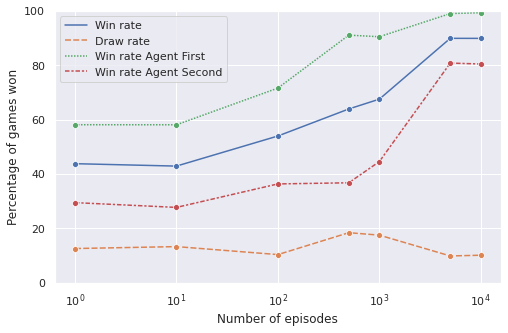

In [40]:
sns.set_theme()
sns.set(rc={'figure.figsize':(8,5)})
results_episodes["total_games"] = results_episodes["win_agent_first"] + results_episodes["win_agent_second"] + \
                                  results_episodes["lose_agent_first"] + results_episodes["lose_agent_second"] + \
                                  results_episodes["even_agent_first"] + results_episodes["even_agent_second"]
results_episodes["Win rate"] = ((results_episodes["win_agent_first"] + results_episodes["win_agent_second"]) / results_episodes["total_games"]) * 100
results_episodes["Draw rate"] = ((results_episodes["even_agent_first"] + results_episodes["even_agent_second"]) / results_episodes["total_games"]) * 100
results_episodes["Win rate Agent First"] = ((results_episodes["win_agent_first"]) / (results_episodes["win_agent_first"] + results_episodes["lose_agent_first"] + results_episodes["even_agent_first"])) * 100
results_episodes["Win rate Agent Second"] = ((results_episodes["win_agent_second"]) / (results_episodes["win_agent_second"] + results_episodes["lose_agent_second"] + results_episodes["even_agent_second"])) * 100

ax = sns.lineplot(data=results_episodes[["Win rate", "Draw rate", "Win rate Agent First", "Win rate Agent Second"]], marker="o")
ax.set(xlabel='Number of episodes', ylabel='Percentage of games won', ylim=(0, 100))
ax.set(xscale="log")
ax.legend(loc='upper left')
plt.savefig("Perf_vs_Episodes.png")
plt.show()

In [41]:
# Evaluates agents performances based on board size
board_sizes = [3, 4, 5, 6, 7]
results_boardsize = dict()
for board_size in board_sizes:
    print(f"Testing board of size {board_size}x{board_size}")
    agent = Agent(size=board_size)
    random_agent = Agent(size=board_size, policy=random_policy)
    game = Game(agent, random_agent, n_dim=2, size=board_size)
    # Early stopping ?
    sarsa(game, agent, random_policy, alpha=0.45, alpha_factor=0.9995, gamma=0.7, epsilon=1.0, epsilon_factor=0.9997, \
          r_win=11, r_lose=0.0, r_even=1.0, r_even2=1.25, num_episodes=10000)
    results_boardsize[agent.q_array.shape[0]] = game.simulate_games(10000)
    print(f"Current results are {results_boardsize}")
results_boardsize = pd.DataFrame(results_boardsize).T
results_boardsize.columns = ["win_agent_first", "lose_agent_first", "even_agent_first", "win_agent_second", "lose_agent_second", "even_agent_second"]

100%|██████████| 1000/1000 [02:05<00:00,  7.95it/s]


Testing board of size 3x3
Current results are {583: (458, 37, 5, 285, 122, 93)}
Testing board of size 4x4
Current results are {583: (458, 37, 5, 285, 122, 93), 5392: (181, 112, 207, 137, 158, 205)}
Testing board of size 5x5
Current results are {583: (458, 37, 5, 285, 122, 93), 5392: (181, 112, 207, 137, 158, 205), 10366: (120, 70, 310, 66, 119, 315)}
Testing board of size 6x6
Current results are {583: (458, 37, 5, 285, 122, 93), 5392: (181, 112, 207, 137, 158, 205), 10366: (120, 70, 310, 66, 119, 315), 16030: (48, 78, 374, 68, 54, 378)}
Testing board of size 7x7
Current results are {583: (458, 37, 5, 285, 122, 93), 5392: (181, 112, 207, 137, 158, 205), 10366: (120, 70, 310, 66, 119, 315), 16030: (48, 78, 374, 68, 54, 378), 22850: (39, 32, 429, 30, 45, 425)}


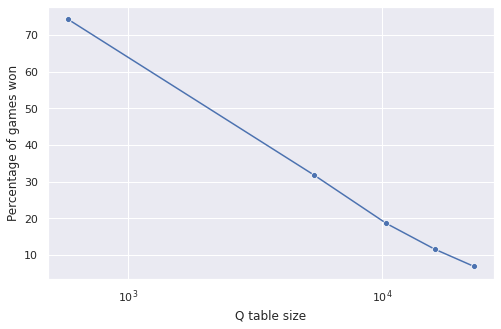

In [43]:
results_boardsize["total_games"] = results_boardsize["win_agent_first"] + results_boardsize["win_agent_second"] + \
                                  results_boardsize["lose_agent_first"] + results_boardsize["lose_agent_second"] + \
                                  results_boardsize["even_agent_first"] + results_boardsize["even_agent_second"]
results_boardsize["Win rate"] = ((results_boardsize["win_agent_first"] + results_boardsize["win_agent_second"]) / results_boardsize["total_games"]) * 100

ax = sns.lineplot(data=results_boardsize["Win rate"], marker="o")
ax.set(xlabel='Q table size', ylabel='Percentage of games won')
ax.set(xscale="log")
plt.savefig("Perf_vs_BoardSize.png")
plt.show()
